## Final Project Writeup 
Roy Phillips

ELEC 483

December 16, 2020

In [1]:
%autosave 10

Autosaving every 10 seconds


**Abstract**: For my final project I sought out to to replicate some of the results from Wu et al. (2017) on Gaussian process based nonlinear latent structure discovery in multivariate spike train data. I specifically wanted to recreate parts of figure 2, specifically 2A) and C) using a P-GPLVM to model the latent processes in noisy simulated sinusoid tuning cures and 2D Gaussian bump tuning curves. I sourght out to recreate the P-GPLVM components of figures 2B) and 2D), showing the tuning curves estimated by this mode, and I intended to include tuning curve estimates from one or two of the other models shown.


#### Background:
Modelling spikecount data with a poisson gaussian process latent variable. This means the spikecount data is a poisson process with a firing rate that has a gaussian process latent variable.

##### The model
1. The spike count data: $\mathbf{Y} \in \mathbb{R}^{N \times T}$ where N is number of neurons and T is the number of time bins
2. Construct generative model of latent structure, a P-dimensional latent variable $\mathbf{x}(t)$, with a set of mapping functions (tuning curves) $\{ h_i(\mathbf{x}) \}$ where i is the index of each neuron.

##### Latent dynamics:
$x_j(t) \sim \mathscr{GP}(0,k_t)$ where $\mathscr{GP}$ is the Gaussian Process and $k_t$ is a covariance function, for this paper, specifically give by $k(t,t') = r \exp(-|t-t'|/l)$, were r is a positive marginal variance and l is a length scale.

The matrix $\mathbf{X} \in \mathbb{R}^{P \times T}$ is the collection of each latent variable vector over all time bins. Each row is a multivariate normal $\mathbf{x}_j \sim \mathit{N}(\mathbf{0}, K_t)$ where $K_t \in \mathbb{R}^{T \times T}$ is the covariance function $k_t$ evaluated for all time bins.

##### Nonlinear mapping

$h: \mathbb{R}^P \rightarrow \mathbb{R}$ denotes the nonlinear function mapping $\mathbf{x}_t$ to a firing rate $\lambda_t$. This is what is called tuning curve in the figure

$f_i(\mathbf{x}) = \log(h_i(\mathbf{x}))$ is the log tuning curve for neuron $i$, modeled with a GP: $f_i(x) \sim \mathscr{GP}(0,k_x)$. As a result $h_i(\mathbf{x}) = \exp(f_i(\mathbf{x}))$.

Here the covariance function is the raidial basis function $k_x(\mathbf(x),\mathbf(x') = \rho \exp(-||\mathbf{x-x'}||_2^2/2\delta^2$.

Each vector $\mathbf{f}_i \in \mathbb{R}^{T \times 1}$ is a multivariate normal distribution given latent vectors of the time bins $\mathbf{x}_{1:T}$. So, $\mathbf{f}_i | \mathbf{x}_{1:T} \sim N(\mathbf{0}, K_x)$. $K_x \in \mathbb{R}^{N\times T}$ is the $k_x$ covariance function evaluated at all pairs latent vectors.

The matrix $\mathbf{F} \in \mathbb{R}^{N \times T}$ is all mapping functions stacked for the N neurons.



##### Poisson Spiking

To derive the spike counts, the model assumes Poisson spiking given latent firing rates. So, $$y_{i,t} |f_i,\mathbf{x}_t \sim Poiss(\exp(f_i(\mathbf{x_t})))$$

Note: issues with source code: some functions do not exist. Trying to run the prior_kernel function with a squared exponential led to a missing function "realbasis_nD_curv_kron".

Dr. Wu doesn't seem to be raising the ff matrix before putting into poissrnd.

Things I have done:
Simulate data in Python.
Attempt to find existing P-GPLVM and decoupled Laplace Approximation libraries
Attempt to hard code my own using the algorithms provided in gaussianprocess.org.
Found library from GuassianProcess.org in matlab
Use matlab code on this generated data
Required: changing parameters to fit my latent approximation
    Includes: iterations, latent function type, prior kernel
Noticed: some issues/differences

Ultimately recreated:

In [2]:
import numpy as np
import numpy.random as rd
import sklearn as sk
import matplotlib.pyplot as plt
import sklearn.gaussian_process as gp
import scipy.spatial.distance
from numpy import matlib
import matplotlib.ticker as mticker
import matplotlib as mpl

rd.seed(483)

In [3]:
# simulate data for sinusoid tuning curve

num_experiments = 10
T = 100
N = 20 # 20 neurons
P = 1 # latent dimensions
phi = np.reshape(rd.uniform(low=0.0, high=2*np.pi, size =N), (N,1))
omega = np.reshape(rd.uniform(low=1.0, high=4.0, size =N), (N,1))
times = np.reshape(np.array(range(T)),(T,1))

In [4]:
#kernel constants 
rhof = 1
ellf = 5
rhox = 1
ellx = 5

def sin_tuning_curve(x,omega=omega, phi=phi):
    """
    x is latent dynamics 1xP array
    returns a sinusoid tuing curve
    """
    F = 3*np.sin(omega@x+phi)-2; 
    return F
    
def fr(f):
    """
    return firing rate, size Nx1
    """
    fr = np.exp(f)
    return fr

def spike_counts(fr):
    """
    return spike count matrix NxT
    """
    spikes = rd.poisson(lam=fr)
    return spikes
    

def abs_exp_kernel(t,rho=rhof, ell=ellf):
    """
    creates absolute exponential kernel matrix, also the matern kernel matrix with nu=1/2
    """
    tdiff = sk.metrics.pairwise_distances(times, metric='l1')
    print(tdiff)
    kt = rho*np.exp(-tdiff/ell)
    return kt

def rbf_kernel(x, rho=rhox, ell=ellx):
    """
    creates radial basis function kernel matrix
    """
    xdiff = sk.metrics.pairwise_distances(times, metric='l2')
    kx = rho*np.exp(-np.square(xdiff)/(2*ell**2)) # adding p ma
    return kx

kt = rbf_kernel(times)

In [5]:
latent_variables = np.empty((P,T, num_experiments))
for exprmnt in range(num_experiments):
    for latent_dim in range(P):
        latent_variables[latent_dim,:,exprmnt]= rd.multivariate_normal(mean=np.zeros((T,)), cov=kt)
    
latent_variable = np.reshape((np.mean(latent_variables, axis=2)), (P,T))

In [6]:
log_tuning_curve = sin_tuning_curve(latent_variable)
fr_sin = fr(log_tuning_curve)
spikes = spike_counts(fr_sin)

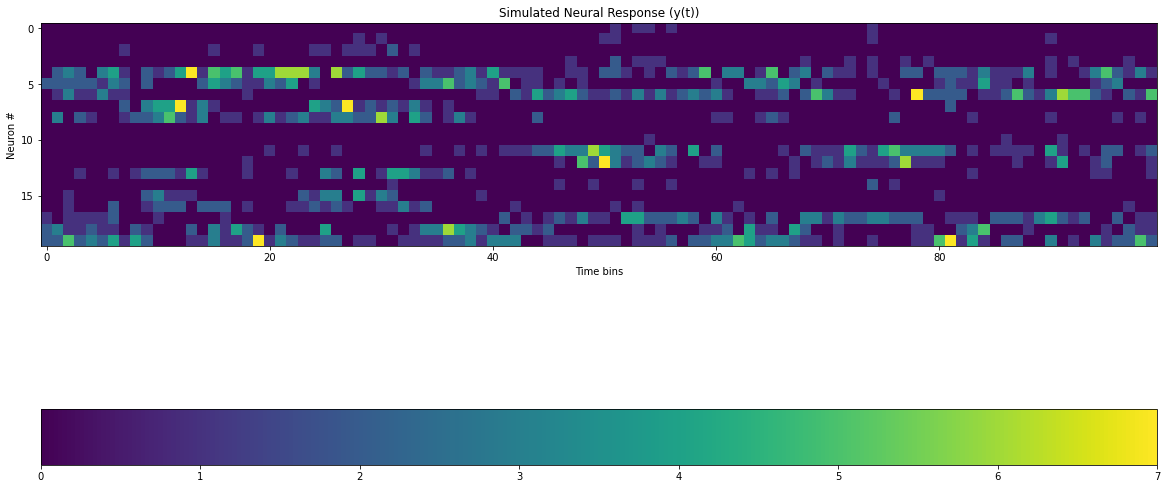

In [7]:
fig,ax = plt.subplots(1,1,figsize=(20,20))
im = ax.imshow(spikes);

ax.set_title("Simulated Neural Response (y(t))");
ax.set_xlabel("Time bins");
ax.set_ylabel("Neuron #");
ax.set_yticks(range(0,19,5))
imp = fig.colorbar(im, orientation='horizontal')

In [8]:
def align_xtrue(xsamp, xtrue):
    """
    align the sample latent variable xsamp w the true
    """
    nx = xtrue.shape[0]
    xmat = np.hstack((np.ones((nx,1)),xsamp))
    wtsaffine = np.linalg.pinv(xmat) @ xtrue
    xsamphat = xmat @ wtsaffine
    return xsamphat, wtsaffine

In [9]:
def gen_grid(gridends,ng, nc):
    """
    gridends is an nc x nc array of endpoints and ng is the number of grid points
    returns ng x nc array
    """
    grid1 = np.array(matlib.repmat(np.linspace(gridends[0],gridends[1],ng),ng,1))
    
    if nc==2:
        xgrid = np.array(np.vstack((grid1.flatten('C'), grid1.flatten('F')))).T
    elif nc==1:
        xgrid = np.array(grid1.flatten('C')).T
    
    return xgrid
    

In [10]:
# Gaussian process latent variable model with gpflow
import gpflow
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf

import gpflow
# from gpflow.utilities import ops, print_summary
# from gpflow.config import set_default_float, default_float, set_default_summary_fmt
# from gpflow.ci_utils import ci_niter

from sklearn import decomposition


/usr/local/Cellar/jupyterlab/2.2.9_1/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/Cellar/jupyterlab/2.2.9_1/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/Cellar/jupyterlab/2.2.9_1/libexec/lib/python3.9/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/Cella

In [11]:
# initialize with PCA
pca = decomposition.PCA(n_components=P)
X_mean_init = pca.fit_transform(spikes.T)
# X_mean_init = np.ones((T,P))

In [12]:
# # pick inducing inputs
inducing_variable = tf.convert_to_tensor(rd.permutation(X_mean_init))

In [13]:
kernel = gpflow.kernels.RBF(lengthscales=ellx,input_dim=P)

In [14]:
gplvm = gpflow.models.GPLVM(
    Y=spikes.T.astype(np.float64),
    latent_dim=P,
    X_mean=X_mean_init,
    kern=kernel,
)

In [15]:
# optimize model
opt = gpflow.train.ScipyOptimizer();
opt.minimize(gplvm, maxiter=1000000);

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2109.980467
  Number of iterations: 161
  Number of functions evaluations: 178


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 2109.980467
  Number of iterations: 161
  Number of functions evaluations: 178


In [16]:
# latent_variable, _= align_xtrue(latent_variable.T, latent_variable.T) does nothing
latent_var_GPLVM = gplvm.X.value
latent_var_GPLVM, _ = align_xtrue(gplvm.X.value, latent_variable.T)

latent_x_pca, _ = align_xtrue(X_mean_init, latent_variable.T)

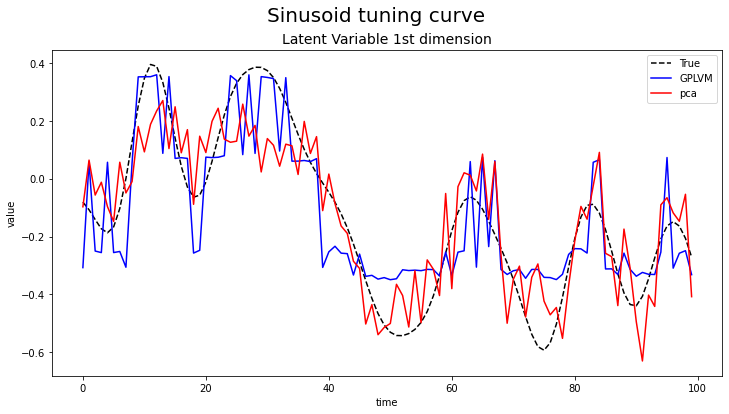

In [17]:
# plot simulated part of figure 2A 
fig,ax = plt.subplots(1,1,figsize=(12,6))

ax.plot(times,latent_variable.T, 'k--', label="True");
ax.plot(times,latent_var_GPLVM, 'b-', label="GPLVM");
ax.plot(times,latent_x_pca, 'r-', label="pca")
ax.set_title("Latent Variable 1st dimension",fontsize=14);
ax.set_xlabel("time");
ax.set_ylabel("value");
# ax.set_ylim([np.min(latent_variable)-.1, np.max(latent_variable)+.1]);
ax.legend()
plt.suptitle("Sinusoid tuning curve", fontsize=20);

###### Sinusoid tuning curve latent variable estimation

The figure above and below are my recreation of the figure 2A from Wu et al (2017). The top figure shows the simulated latent variable with a black dotted line, overlaid with ppca and gpflow's GPLVM. As expected, these dimensional reduction algorithms roughly approximate the latent gaussian process, but do not do so very accurately, as the GPLVM model does not include the poisson mapping from $\mathbf{f}$ to $\mathbf{y}$.


The figure below was the result of adapted MATLAB code to run P-GPLVM. We see the approximation is much better, especially since this was done on 500 iterations and 23 seconds.

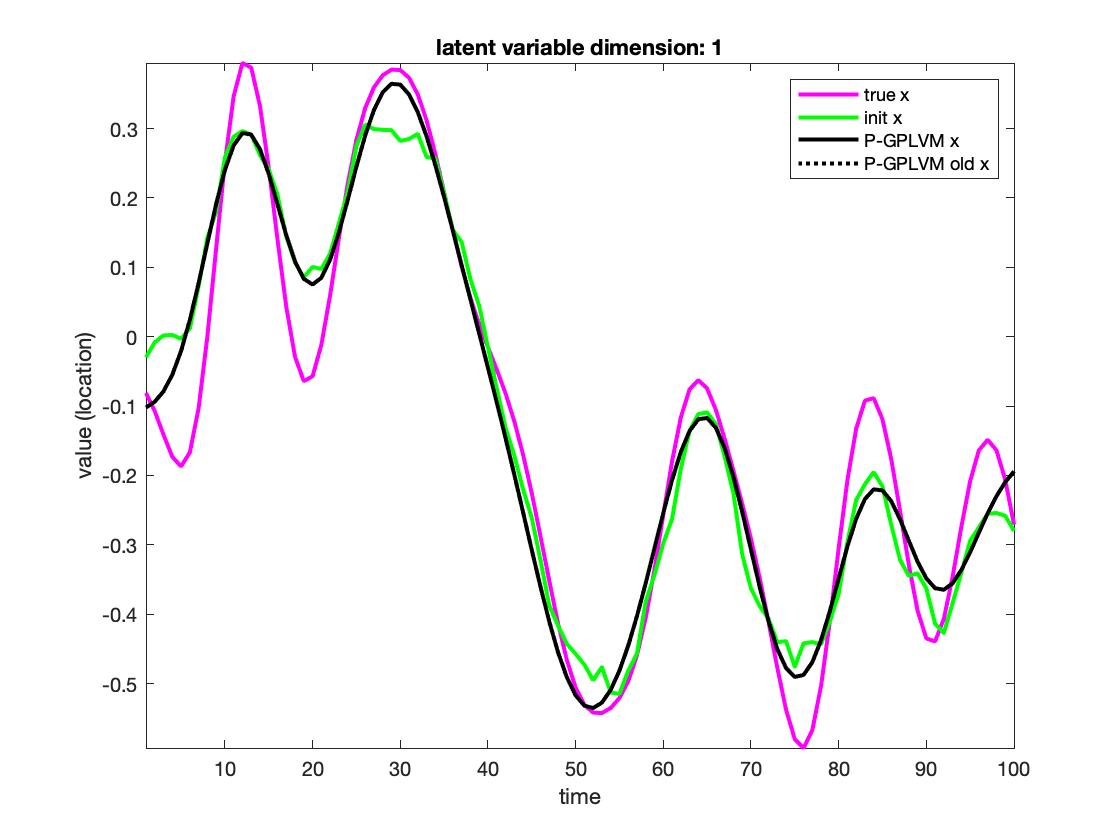

In [34]:
from IPython.display import Image
Image("figs/latent_gplvm_sin.jpg")

In [18]:
# plot simulated part of figure 2B
xgrid = np.reshape(np.linspace(np.min(latent_variable), np.max(latent_variable), num=50),(1,50))

latent_func_GPLVM = np.squeeze(np.array(gplvm.predict_f_samples(xgrid, len(xgrid.T)))).T # supposedly returns samples of the latent function but it does not look great

true_tuning_curve = sin_tuning_curve(xgrid)

In [19]:
# # Visualizing all tuning curves and firing rates to select representative ones
# # uncomment below to see the log firing rate and firing rate for all neurons

# fig,ax = plt.subplots(N,3,figsize=(12,48),sharex=True,sharey=True)
# for neur in range(N):
#     ax[neur,0].plot(xgrid.T,true_tuning_curve[neur,:], 'k--', );
#     # ax[neur,0].plot(xgrid.T,latent_func_GPLVM[neur,:], 'b-');  # uncomment to see what the "latent function" GPLVM returns
     
#     ax[neur,1].plot(xgrid.T,np.exp(true_tuning_curve[neur,:]), 'k--');
    
#     # using the latent variable and fr in spike simulation
#     ax[neur,2].plot(latent_variable.T, fr_sin[neur,:])
    
# fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.xlabel("Location")
# plt.ylabel("Value")
# plt.title("Left: Log FR,          Middle: FR from xgrid,          Right: FR from latent variable")

# plt.suptitle("Sinusoid tuning curves: Left: log firing rate, Right: firing rate", fontsize=20);

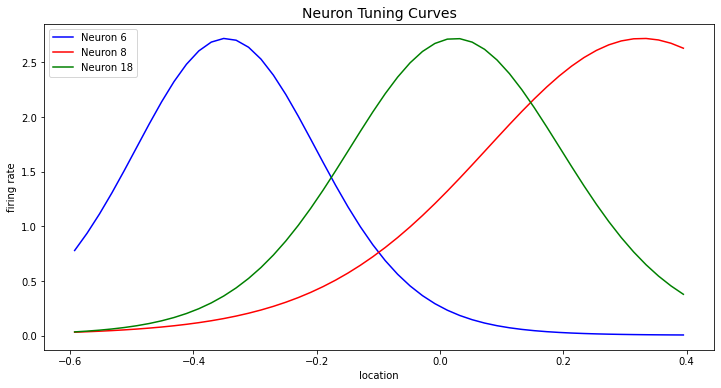

In [20]:
fig,ax = plt.subplots(1,1,figsize=(12,6))

depict_neurons = [6,8,18]
ax.plot(xgrid.T,np.exp(true_tuning_curve[depict_neurons[0],:]), 'b-', label="Neuron {}".format(depict_neurons[0]));
ax.plot(xgrid.T,np.exp(true_tuning_curve[depict_neurons[1],:]), 'r-', label="Neuron {}".format(depict_neurons[1]));
ax.plot(xgrid.T,np.exp(true_tuning_curve[depict_neurons[2],:]), 'g-', label="Neuron {}".format(depict_neurons[2]));
ax.set_title("Neuron Tuning Curves",fontsize=14);
ax.set_xlabel("location");
ax.set_ylabel("firing rate");
ax.legend()

###### Sinusoid tuning curve latent variable estimation

The figure above and below are my recreation of the figure 2B from Wu et al (2017). The top figure shows the true tuning curve generated from the latent variable.


The figure below was the result mapped the estimated latent variable to a tuning curve, and we can see that the peaks are roughly similar. With better convergence the widths may approximate the shape

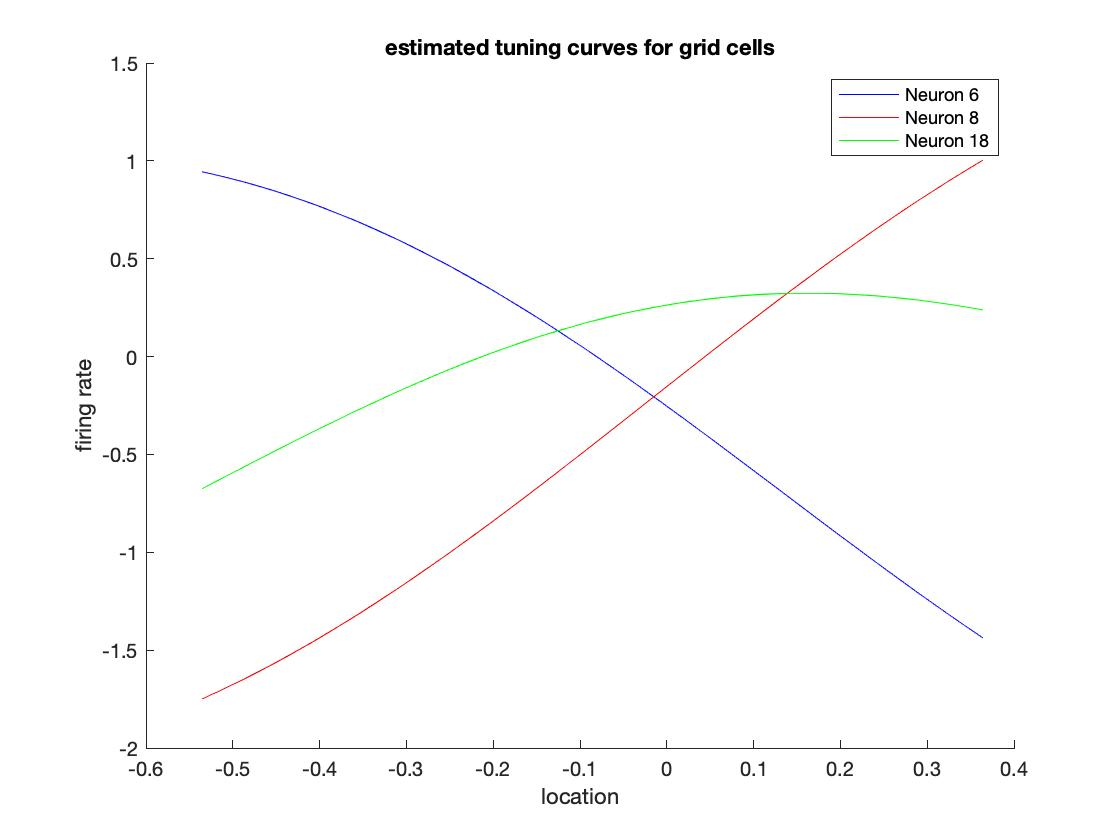

In [35]:
Image("figs/estimated_tc_sin.jpg")

In [21]:
#### simulate data for 2D gaussian bump
# rd.seed(483)
num_experiments = 10
T = 100
N = 20 # 20 neurons
P_bump = 2 # latent dimensions
phi = np.reshape(rd.uniform(low=0.0, high=2*np.pi, size =N), (N,1))
omega = np.reshape(rd.uniform(low=1.0, high=4.0, size =N), (N,1))
times = np.reshape(np.array(range(T)),(T,1))



# # centers for each neuron
centers = np.empty((N,P_bump))
for dim in range(P_bump):
    temp_centers = np.linspace(-6,6,num=N)
    rd.shuffle(temp_centers)
    centers[:,dim]= temp_centers    

In [22]:
#kernel constants 
rho_gaus = 20 # 1 generates a good looking spike set
ell_gaus = 1
#gaussian centers
def gaussian_bump_tuning_curve(x, z, rho=rho_gaus, ell=ell_gaus):
    """
    unimodal Gaussian bump in 2D space
    """
    pdist = sk.metrics.pairwise_distances(x,z, metric='l2')
    gaus_bump = rho*np.exp(-np.square(pdist)/(2*ell**2))
    return gaus_bump 

In [23]:
latent_variables_bump= np.empty((P_bump,T, num_experiments))
for exprmnt in range(num_experiments):
    for latent_dim in range(P_bump):
        latent_variables_bump[latent_dim,:,exprmnt]= rd.multivariate_normal(mean=np.zeros((T,)), cov=kt)
    
latent_variable_bump = np.reshape((np.mean(latent_variables_bump, axis=2)), (P_bump,T))

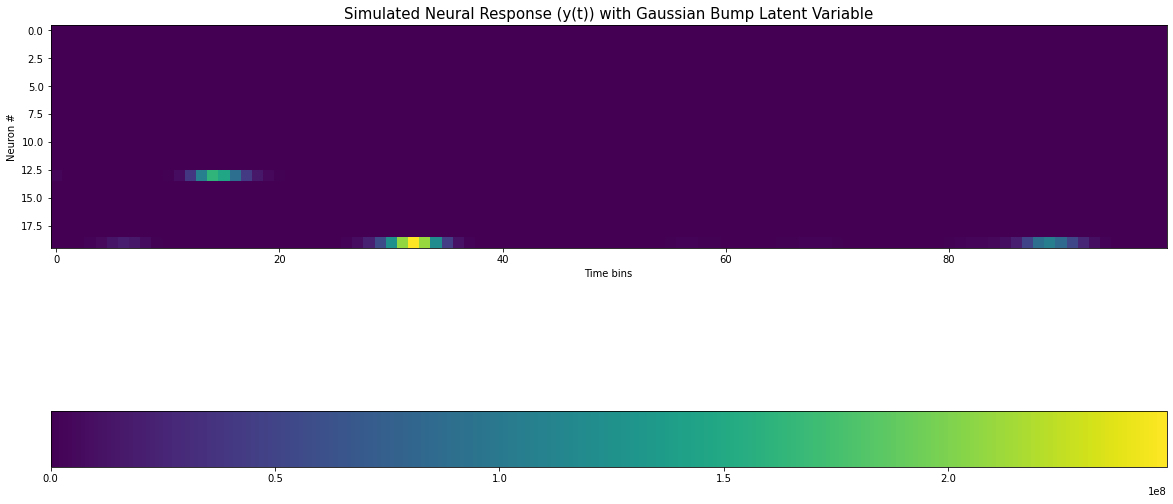

In [24]:
log_tuning_curve_bump = gaussian_bump_tuning_curve(latent_variable_bump.T,centers)
fr_bump = fr(log_tuning_curve_bump)
spikes_bump = spike_counts(fr_bump).T

fig,ax = plt.subplots(1,1,figsize=(20,20))
im_bump = ax.imshow(spikes_bump);

ax.set_title("Simulated Neural Response (y(t)) with Gaussian Bump Latent Variable", fontsize=15);
ax.set_xlabel("Time bins");
ax.set_ylabel("Neuron #");

fig.colorbar(im_bump, orientation='horizontal')

In [25]:
# xgrid_bump = gen_grid([np.min(latent_variable_bump), np.max(latent_variable_bump)],25,1)

In [26]:
# initialize with PCA
pca_bump = decomposition.PCA(n_components=P_bump)
X_mean_init_bump = np.ones((T,P_bump))
kernel_bump = gpflow.kernels.RBF(lengthscales=ell_gaus,input_dim=P_bump)
gplvm_bump= gpflow.models.GPLVM(
    Y=spikes_bump.T.astype(np.float64),
    latent_dim=P_bump,
    X_mean=X_mean_init_bump,
    kern=kernel_bump,
)
# optimize model
opt_bump = gpflow.train.ScipyOptimizer();
opt_bump.minimize(gplvm_bump, maxiter=1000000);

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 366007.114605
  Number of iterations: 92
  Number of functions evaluations: 93


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: 366007.114605
  Number of iterations: 92
  Number of functions evaluations: 93


In [27]:
latent_var_GPLVM_bump = gplvm_bump.X.value
latent_var_GPLVM_bump, _ = align_xtrue(latent_var_GPLVM_bump, latent_variable_bump.T)


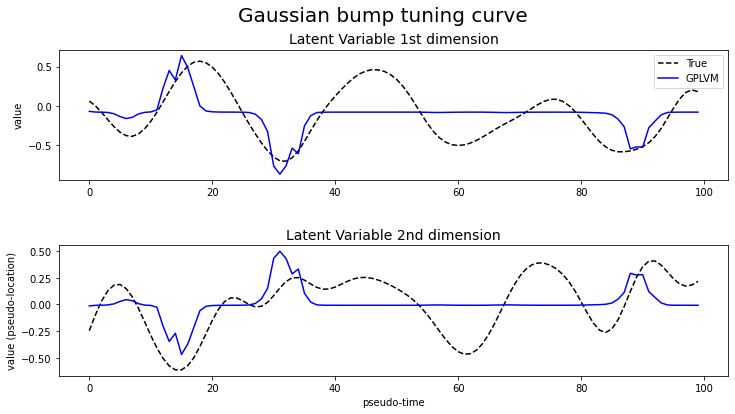

In [28]:
# plot simulated part of figure 2C 
fig,ax = plt.subplots(2,1,figsize=(12,6))

ax[0].plot(times,latent_variable_bump[0,:].T, 'k--', label="True");
ax[0].plot(times,latent_var_GPLVM_bump[:,0], 'b-', label="GPLVM");
ax[0].set_title("Latent Variable 1st dimension",fontsize=14);
ax[0].set_ylabel("value");
# ax.set_ylim([np.min(latent_variable)-.1, np.max(latent_variable)+.1]);
ax[0].legend()

ax[1].plot(times,latent_variable_bump[1,:].T, 'k--');
ax[1].plot(times,latent_var_GPLVM_bump[:,1], 'b-');                                       
ax[1].set_title("Latent Variable 2nd dimension",fontsize=14);
ax[1].set_ylabel("value (pseudo-location)");
ax[1].set_xlabel("pseudo-time")
plt.suptitle("Gaussian bump tuning curve", fontsize=20);
plt.subplots_adjust(hspace=0.5)

###### Sinusoid tuning curve latent variable estimation

The figure above and below are my recreation of the figure 2C from Wu et al (2017). The top figure shows the simulated latent variable with a black dotted line, overlaid gpflow's GPLVM. Some iterations looked better than others, but this averaged latent has a large inaccurate section from 40 to 80 perhaps due to a bad objective function combined with the missing Poisson output.

The figure below was the result of adapted MATLAB code to run P-GPLVM, with 5000 iterations. We see the approximation is much better, and it took about 200 seconds. Interestingly it did appear to overly smooth some areas, compared to the initial x (which was a jittered PLDS). Innaccuracies here may be due to a flaw in the generation of spikes, or perhaps a latent function reaching a wrong local minima.

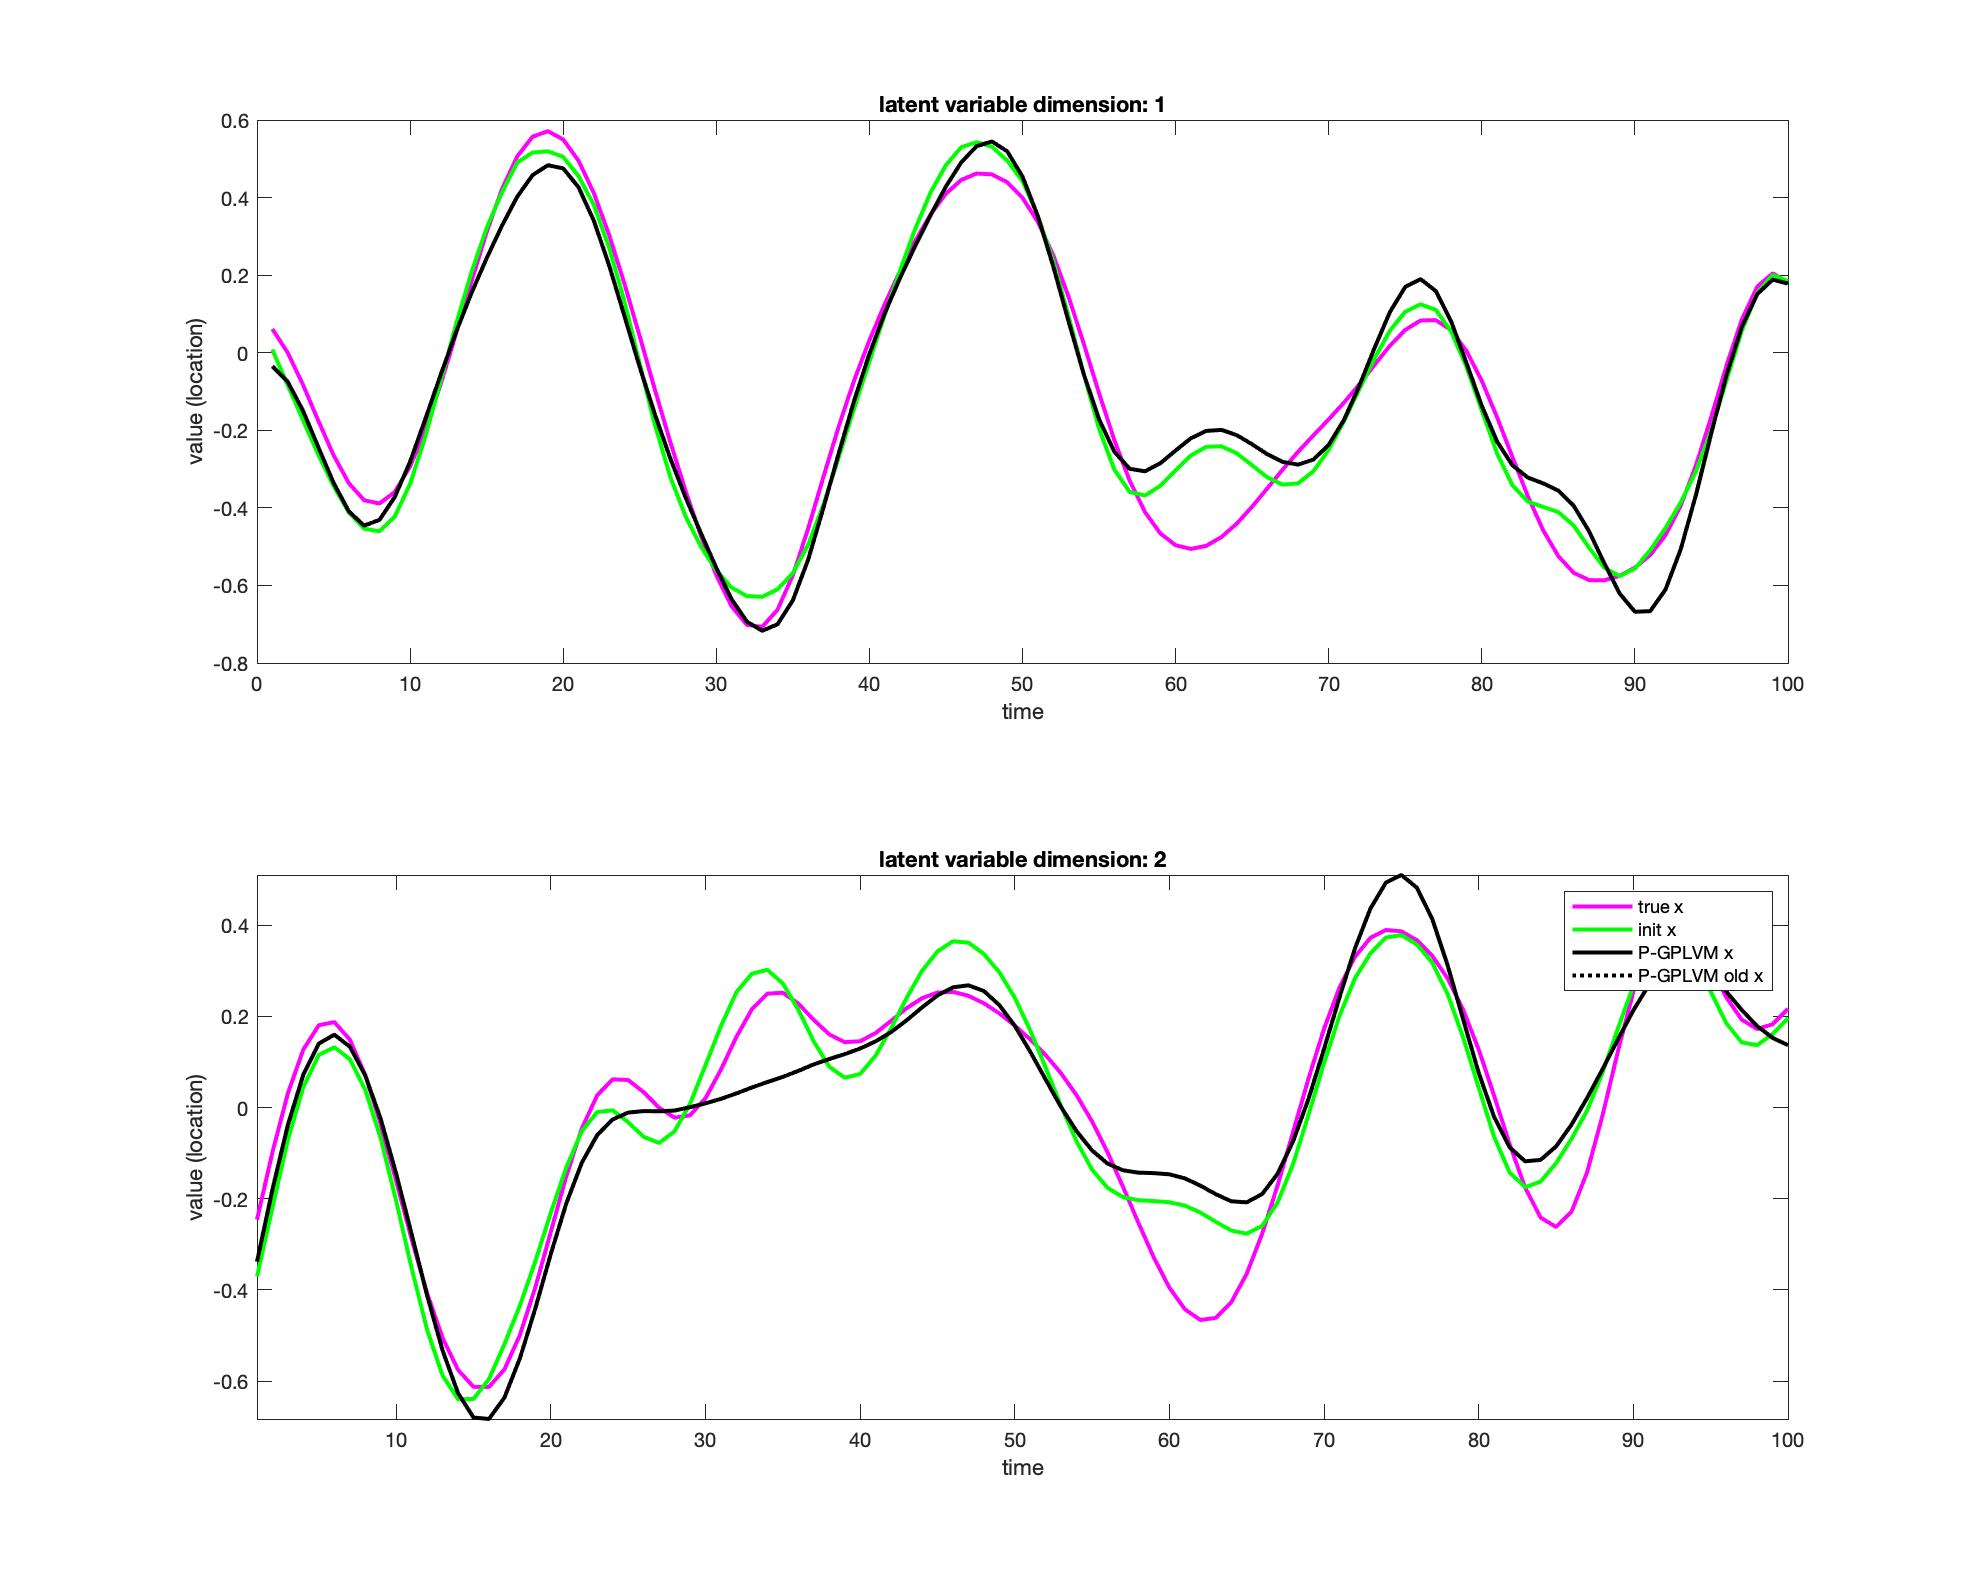

In [37]:
Image("figs/latent_gplvm_gausbump.jpg")

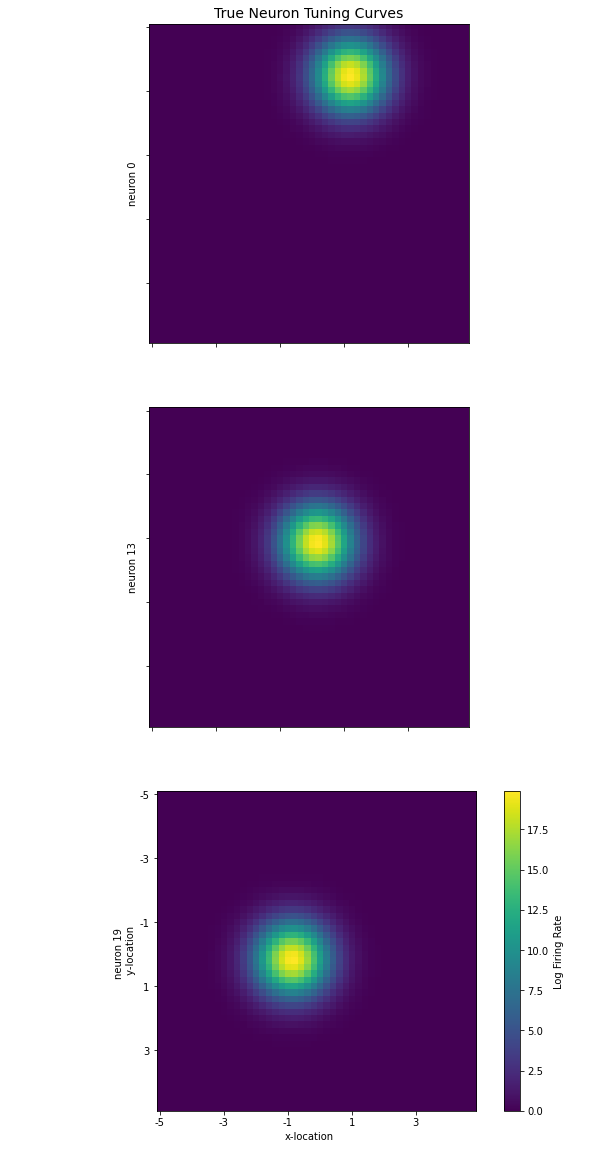

In [29]:
# plot simulated part of figure 2D
xgrid_bump= gen_grid([-6,6],50,2)

true_tuning_curve_bump = gaussian_bump_tuning_curve(xgrid_bump, centers)
# latent_func_GPLVM_bump = np.squeeze(np.array(gplvm_bump.predict_f_samples(xgrid_bump, len(xgrid_bump)))) #  error in Cholesky decomposition, tried resizing xgrid_bump to (100,2) to match latent_variable_bump but still didn't work


fgrid_bump_1 = true_tuning_curve_bump[:,1].reshape((50,-1))
fgrid_bump_2 = true_tuning_curve_bump[:,13].reshape((50,-1))
fgrid_bump_3= true_tuning_curve_bump[:,19].reshape((50,-1))
fig,ax = plt.subplots(3,1,figsize=(10,20))


ax[0].imshow(fgrid_bump_1);
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])


ax[0].set_title("True Neuron Tuning Curves",fontsize=14);
ax[0].set_ylabel("neuron 0");

ax[1].imshow(fgrid_bump_2);
ax[1].set_ylabel("neuron 13");
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])

im = ax[2].imshow(fgrid_bump_3);
ax[2].set_ylabel("neuron 19 \n y-location");

ticks_loc = ax[2].get_yticks().tolist()
ax[2].yaxis.set_major_locator(mpl.ticker.FixedLocator(ticks_loc))
ax[2].xaxis.set_major_locator(mpl.ticker.FixedLocator(ticks_loc))
ax[2].set_yticklabels(range(-7,7,2));
ax[2].set_xticklabels(range(-7,7,2));


fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("x-location")
cbar = plt.colorbar(im, ax=ax[2])
cbar.set_label("Log Firing Rate")
## save simulated dataplt.suptitle("2D Gaussian bump tuning curve", fontsize=20);

###### Sinusoid tuning curve latent variable estimation

The figure above and below are my partial recreation of the figure 2D from Wu et al (2017). The top figure shows the true tuning curve generated from the latent variable.


The figure below was the result mapped the estimated latent variable to a tuning curve, and we can see that the peaks are roughly similar. This is not as accurate as the authors, likely due to the same reason the latent variable is inaccurate, as well as a potential misinterpretation of the $\mathbf{f_{grid}}$ matrix.

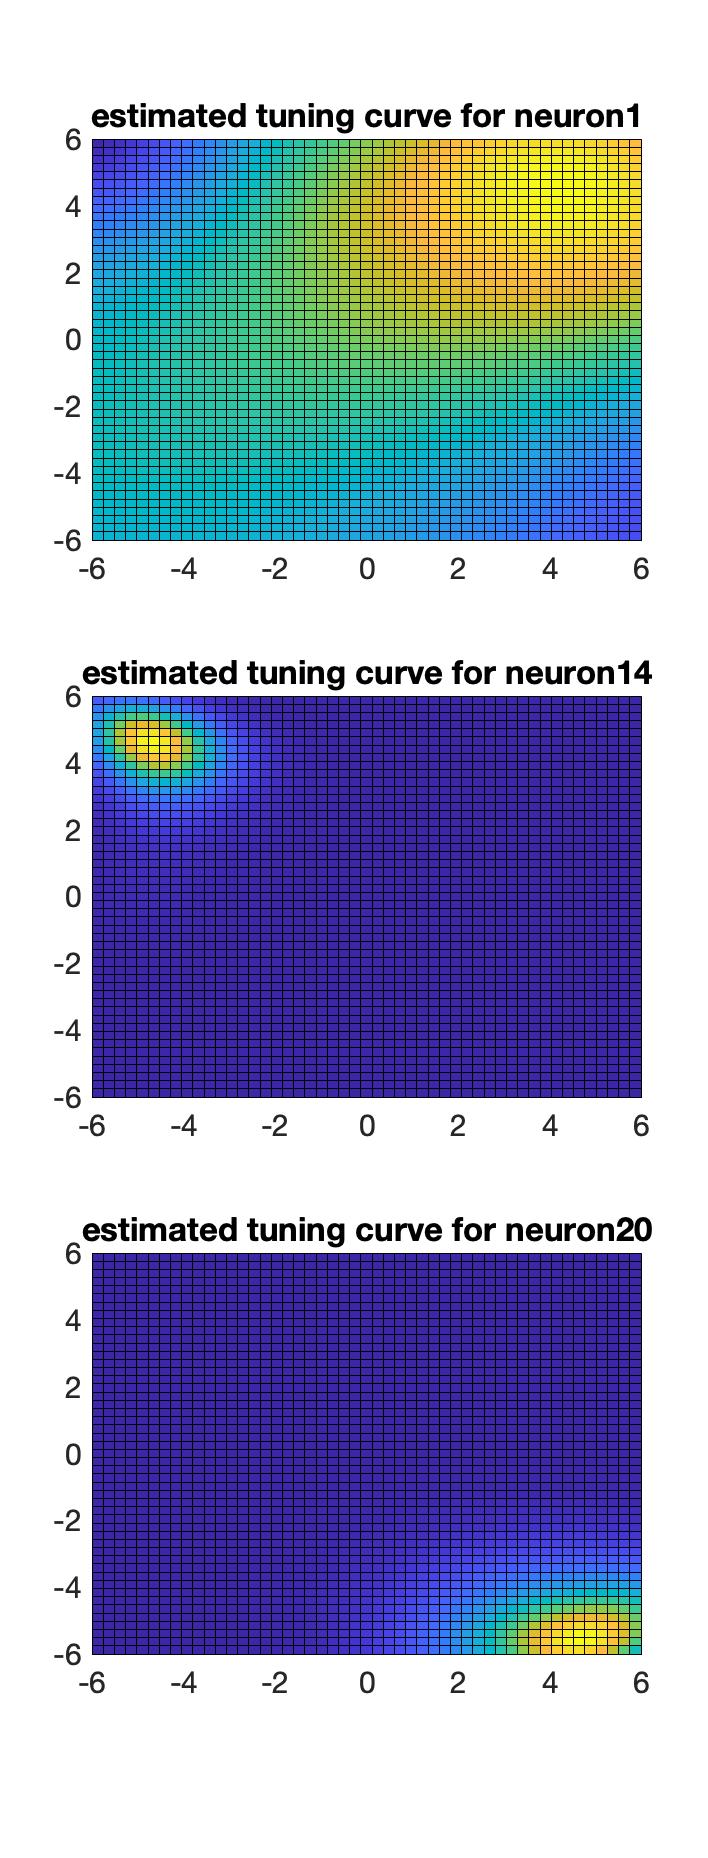

In [38]:
Image("figs/estimated_tc_bump.jpg")

In [30]:
## save simulated data

import pandas as pd 
sim_spikes_sin = spikes
np.savetxt('sim_spikes_sin.csv', sim_spikes_sin,delimiter=",")
np.savetxt('latent_sin.csv', latent_variable,delimiter=",")
np.savetxt('logFR_sin.csv', log_tuning_curve,delimiter=",")

np.savetxt('latent_bump.csv', latent_variable_bump,delimiter=",")
np.savetxt('sim_spikes_bump.csv', spikes_bump,delimiter=",")
np.savetxt('logFR_bump.csv', log_tuning_curve_bump,delimiter=",")

np.savetxt('gaus_centers.csv', centers, delimiter=",")
np.savetxt('kt.csv', kt,delimiter=",")
sin_params = np.squeeze(np.array([omega, phi])).T
pd.DataFrame(sin_params, columns=["omega","phi"]).to_csv("sin_params.csv")

### Discussion

I was able to successfully use the P-GPLVM generative model to simulate neural with a sinusoidal tuning curve and gaussian bump. Implementing the decoupled Laplacian Approximation proved challenging. To my knowledge, no library exists in Python for P-GPLVM, and the GPLVM models, shown in the figures below, are approximating a slightly different latent variable. As a result I adapted some of the MATLAB latent variables to generate the estimated tuning curve and latent variables. 

#### Transition to MATLAB Implementation
I initially attempted to recreate the decoupled Laplace Algorithm 1 from Wu et al. 2017, by referencing Carl Rasmussen and Chris Williams. _Gaussian Processes for Machine Learning_. MIT Press, 2006 found [here](http://gaussianprocess.org/gpml/)

However, I struggled to create a function to compute the posterior mode, and realized that Rasmussen and Williams created a library in MATLAB to support. Additionally, I looked over the repository used by Anqi Wu (found [here](https://github.com/waq1129/LMT)) and saw that the author relied extensively on that library. Because I could not find another suitable python library for these Guassian Process estimation functions, I transitioned to MATLAB to implement L-GPLVM and decoupled Laplace.

The figures below come from running my MATLAB code. While I did not recreate the entire algorithm, I tuned the parameters and modified the kernel to work with my simulated data. Additionally, I recreated analysis for ________ the sin. All code can be found _______

**What I learned**

This project gave me much confidence in using generative models to simulate data, and more experience estimating the latent variables in that model.

##### References:
- A. Wu, N.G. Roy, S. Keeley, J.W. Pillow
Gaussian process based nonlinear latent structure discovery in multivariate spike train data [https://pillowlab.princeton.edu/pubs/Wu17_PoissGPLVM_nips.pdf]
    
- Carl Rasmussen and Chris Williams. Gaussian Processes for Machine Learning. MIT Press, 2006 [http://gaussianprocess.org/gpml/chapters/RW.pdf]

- Anqi Wu. LMT (2019), GitHub repository, https://github.com/waq1129/LMT

The functions below were my initial framework to build the needed algorithms.

In [31]:
from pyGPs.Optimization import minimize, scg

def decoupled_laplace(y_i, Xk, p=spike_counts):
    """
    Input is a data observation y and the latent variable matrix X at iteration k-1
    """
    
    [N, T] = y_i.shape()
    
    # step 1
    Kx = rbf_kernel(Xk)
    fnew = compute_posterior_mode(K=Kx, y=y_i,x=Xk, p=p) 
    Ak = compute_precision_matrix(yi,Ak, fnew)
    qfun = rd.multivariate_normal(fnew,np.linalg.inv(Ak))
    
    # step 2
    Sk = np.linalg.inv(Ak-np.linalg.inv(Kx))
    mk = Sk @ Ak @ fnew
    
    # step 3
    Afunc = lambda x: np.linalg.inv(Sk) + np.linalg(rbf_kernel(x))
    fnewfunc = lambda x: np.linalg.inv(Afunc(x)) @ np.linalg.inv(Sk)*mk
    
    f_x = fnewfunc(Xk)
    Wi = np.linalg.inv(Sk)
    # step 4
    log_q = (log_p(y,fnewfunc) - 
             1/2 * f_x.T @ np.linalg.inv(Kx)*f_x - 
             1/2*np.log(np.abs(np.identity(t) + Kx @ Wi)))  
    
    # step 5
    Xknew = np.argmax(sum(log_q)*prob_x(Xk))
    
    return Xknew

# estimate X and f with decoupled laplace
ffmat = np.sqrt(spikes)

In [32]:
def compute_posterior_mode(K, y, p, x):
    """
    Attempt to run Algorithm 3.1 from Rasmussen & Williams
    K = covariance matrix
    y = ±1 targets # this is for binary laplace, but Wu references this section specifically
    p = p(y|f) (likelihood function)
    Where does xk come into play?
    
    returns posterior mode and approx. log marg. likelihood
    """
    f = np.zeros((len(y),1))
    
    convergence = 1e2
    objectiveOld = -np.inf
    while objective_diff > convergence:
        W = -laplace(np.log(p(y,f))) # need the laplace of the likelihood function
        B = np.identity(length(W)+ W**(1/2)@K@W**(1/2))
        L = np.linalg.cholesky(B)
        b = W*f + nabla(np.log(p(y,f))) # need the gradient of log likelihood
        temp = np.linalg.lstsq(L,W**(1/2)@K@b)
        a = b - W**(1/2)*np.linalg.lstsq(L.T, temp)
        f = K@a
        objectiveNew = -1/2*a.T@f+np.log(p(y,f))
        objective_diff = abs(objectiveNew-objectiveOld)
        objectiveOld = objectiveNew
    logq = -1/2*a.T@f+np.log(p(y,f))-sum(np.log(L))
    return f, logq
            

In [33]:
# utils for solving cholesky and pdinv (from GPys: https://gpy.readthedocs.io/en/deploy/_modules/GPy/util/linalg.html)

from scipy import linalg
from scipy.linalg import lapack, blas
import logging

def pdinv(A, *args):
    """
    :param A: A DxD pd numpy array

    :rval Ai: the inverse of A
    :rtype Ai: np.ndarray
    :rval L: the Cholesky decomposition of A
    :rtype L: np.ndarray
    :rval Li: the Cholesky decomposition of Ai
    :rtype Li: np.ndarray
    :rval logdet: the log of the determinant of A
    :rtype logdet: float64

    """
    L = jitchol(A, *args)
    logdet = 2.*np.sum(np.log(np.diag(L)))
    Li = dtrtri(L)
    Ai, _ = dpotri(L, lower=1)
    # Ai = np.tril(Ai) + np.tril(Ai,-1).T
    symmetrify(Ai)

    return Ai, L, Li, logdet

def jitchol(A, maxtries=5):
    A = np.ascontiguousarray(A)
    L, info = lapack.dpotrf(A, lower=1)
    if info == 0:
        return L
    else:
        diagA = np.diag(A)
        if np.any(diagA <= 0.):
            raise linalg.LinAlgError("not pd: non-positive diagonal elements")
        jitter = diagA.mean() * 1e-6
        num_tries = 1
        while num_tries <= maxtries and np.isfinite(jitter):
            try:
                L = linalg.cholesky(A + np.eye(A.shape[0]) * jitter, lower=True)
                return L
            except:
                jitter *= 10
            finally:
                num_tries += 1
        raise linalg.LinAlgError("not positive definite, even with jitter.")
    import traceback
    try: raise
    except:
        logging.warning('\n'.join(['Added jitter of {:.10e}'.format(jitter),
            '  in '+traceback.format_list(traceback.extract_stack(limit=3)[-2:-1])[0][2:]]))
    return L